In [31]:
from faker import Faker
import pandas as pd
from random import randint, choice, uniform
from datetime import datetime, timedelta

# Initialize Faker
fake = Faker()

# Generate a list of trader IDs and companies
trader_ids = [fake.random_number(digits=5) for _ in range(100)]  # 100 unique trader IDs
companies = [fake.company() for _ in range(10)]  # 100 unique companies

# Define a list of currency pairs and corresponding spot rate range
currency_data = {
    'EUR/USD': {'spot_rate_range': (1.1, 1.2)},
    'USD/JPY': {'spot_rate_range': (105, 115)},
    'GBP/USD': {'spot_rate_range': (1.3, 1.4)},
    'USD/CHF': {'spot_rate_range': (0.9, 1.0)},
    'USD/CAD': {'spot_rate_range': (1.2, 1.3)},
    'AUD/USD': {'spot_rate_range': (0.7, 0.8)},
    'NZD/USD': {'spot_rate_range': (0.6, 0.7)},
}

# Define the structure of your transaction data
def generate_transaction():
    currency_pair = choice(list(currency_data.keys()))
    buy_currency, sell_currency = currency_pair.split('/')
    rate_data = currency_data[currency_pair]
    buy_sell_indicator = choice(['Buy', 'Sell'])
    quantity = randint(1, 10000) * 10000
    spot_rate = round(fake.pyfloat(right_digits=4, positive=True, min_value=rate_data['spot_rate_range'][0], max_value=rate_data['spot_rate_range'][1]), 4)  # generating a spot rate within the range
    # calculate a forward rate within 1% of the spot rate
    forward_rate = round(spot_rate * uniform(0.99, 1.01), 4)
    return {
        'TransactionID': fake.unique.random_number(digits=8),
        'TradingDate': fake.date_between(start_date='-1y', end_date='today'),
        'MaturityDate': fake.date_between(start_date='today', end_date='+1y'),
        'ExecutionTime': (datetime.now()-timedelta(seconds=randint(1,86400))).strftime('%H:%M:%S'),
        'InstrumentID': fake.random_number(digits=12),
        'TraderID': choice(trader_ids),  # select a trader ID from the list
        'BuyCurrency': buy_currency,
        'SellCurrency': sell_currency,
        'SpotRate': spot_rate,
        'ForwardRate': forward_rate,
        'BuySellIndicator': buy_sell_indicator,
        'BuyNotional': round(quantity, 2),
        'SellNotional': round(quantity * spot_rate, 2),
        'Counterparty': choice(companies)  # select a company from the list
    }

# Generate n transactions
def generate_transactions(n=100):
    return [generate_transaction() for _ in range(n)]

# Usage
data = generate_transactions(1000)  # generate 10,000 transactions
transactions_df = pd.DataFrame(data)


In [32]:
transactions_df

,TransactionID,TradingDate,MaturityDate,ExecutionTime,InstrumentID,TraderID,BuyCurrency,SellCurrency,SpotRate,ForwardRate,BuySellIndicator,BuyNotional,SellNotional,Counterparty
0,27235278,2024-01-01,2024-07-09,04:11:38,970106766956,30802,USD,CAD,1.2200,1.2295,Buy,48580000,5.926760e+07,Smith-Alexander
1,66323644,2023-09-07,2024-12-31,07:57:54,302921819690,83955,USD,JPY,114.3816,115.1570,Sell,41870000,4.789158e+09,Harris-Hall
2,44416491,2023-07-02,2025-06-07,14:42:27,697951000604,3761,USD,CHF,0.9029,0.9069,Sell,50390000,4.549713e+07,Harris LLC
3,89111042,2023-10-22,2024-07-17,03:31:42,479269425464,74112,USD,CHF,0.9117,0.9207,Buy,8820000,8.041194e+06,Harris LLC
4,93675619,2024-01-21,2025-01-10,08:13:46,614243312653,77519,USD,JPY,109.1906,109.2462,Sell,12000000,1.310287e+09,Odom-Montgomery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,83354471,2024-06-05,2025-03-24,05:58:52,873628080351,25729,USD,CHF,0.9071,0.9148,Buy,56680000,5.141443e+07,Harris-Hall
996,30549306,2023-12-24,2024-08-06,11:33:19,705228685821,99541,NZD,USD,0.6648,0.6694,Buy,88680000,5.895446e+07,Ramirez Group
997,55004870,2024-05-09,2025-06-02,22:08:22,344537610357,73091,USD,JPY,108.8225,109.3739,Sell,42080000,4.579251e+09,"White, Navarro and Bruce"
998,52358695,2024-02-12,2024-11-10,11:02:00,75892645747,81466,AUD,USD,0.7554,0.7604,Sell,53090000,4.010419e+07,Taylor Inc


In [33]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.stats import norm

# Assume transaction_df is already provided
# Define a time grid
time_grid = list(range(1, 15)) + list(range(14, 91, 7)) + list(range(90, 366, 30))

# Mock functions to fetch volatility and correlation matrix
def fetch_vol_and_correlation(alternative=False):
    if alternative == False:
        volatilities_usd = {
            'EUR': 0.1,
            'JPY': 0.15,
            'GBP': 0.12,
            'CHF': 0.1,
            'CAD': 0.13,
            'AUD': 0.14,
            'NZD': 0.15
        }
    else:
        volatilities_usd = {
            'EUR': 0.12,
            'JPY': 0.15,
            'GBP': 0.12,
            'CHF': 0.2,
            'CAD': 0.16,
            'AUD': 0.14,
            'NZD': 0.2
        }

    correlation_matrix_usd = np.array([
        [1.0, 0.3, 0.2, 0.1, 0.1, 0.2, 0.1],
        [0.3, 1.0, 0.4, 0.2, 0.2, 0.1, 0.2],
        [0.2, 0.4, 1.0, 0.3, 0.3, 0.2, 0.3],
        [0.1, 0.2, 0.3, 1.0, 0.4, 0.3, 0.2],
        [0.1, 0.2, 0.3, 0.4, 1.0, 0.2, 0.1],
        [0.2, 0.1, 0.2, 0.3, 0.2, 1.0, 0.4],
        [0.1, 0.2, 0.3, 0.2, 0.1, 0.4, 1.0]
    ])
    return volatilities_usd, correlation_matrix_usd

# Functions to calculate PFE
def convert_to_usd(notional, currency, spot_rate):
    if currency == 'USD':
        return notional
    return notional / spot_rate

# Create an exposure vector
def create_exposure_vector(buy_currency, sell_currency, buy_notional_usd, sell_notional_usd, volatilities_usd):
    currencies = list(volatilities_usd.keys())
    exposures = np.zeros(len(currencies))

    for i, currency in enumerate(currencies):
        if currency == buy_currency:
            exposures[i] += buy_notional_usd
        if currency == sell_currency:
            exposures[i] -= sell_notional_usd
    return exposures

# Create an exposure vector
def create_aggregated_exposure_vector(aggregated_exposures, volatilities_usd):
    currencies = list(volatilities_usd.keys())
    exposures = np.zeros(len(currencies))

    for currency, notional in aggregated_exposures.items():
        if currency in currencies:
            index = currencies.index(currency)
            exposures[index] = notional
    return exposures


def calculate_pfe_with_cov_matrix(exposures, days, cov_matrix, confidence_level=0.99):
    # ensure that the length of exposure is equal to a side of the covariance matrix
    if len(exposures) != cov_matrix.shape[0]:
        raise ValueError("Length of exposures should match the covariance matrix")

    exposures_vector = np.array(exposures)
    # adjust the covariance matrix for the number of days, the covariance matrix is assumed to be annualized
    cov_matrix = cov_matrix * days / 365

    variance = exposures_vector.T @ cov_matrix @ exposures_vector
    stddev = np.sqrt(variance)
    z_score = norm.ppf(confidence_level)

    pfe = stddev * z_score
    return pfe


def calculate_pfe_for_trade(row, volatilities, cov_matrix, time_grid, mpor):
    pfe_results = {}
    buy_currency = row['BuyCurrency']
    sell_currency = row['SellCurrency']
    spot_rate = row['SpotRate']
    buy_notional_usd = convert_to_usd(row['BuyNotional'], buy_currency, spot_rate)
    sell_notional_usd = convert_to_usd(row['SellNotional'], sell_currency, spot_rate)

    for days in time_grid:
        if row['MaturityDate'] < row['TradingDate'] + timedelta(days=days):
            continue  # Exclude matured trades

        exposures = create_exposure_vector(buy_currency, sell_currency, buy_notional_usd, sell_notional_usd, volatilities)

        standalone_pfe = calculate_pfe_with_cov_matrix(exposures, days, cov_matrix, confidence_level=0.99)
        collateralized_pfe = calculate_pfe_with_cov_matrix(exposures, mpor, cov_matrix, confidence_level=0.99)

        pfe_results[days] = {
            'Standalone': standalone_pfe,
            'Collateralized': collateralized_pfe
        }

    return pfe_results

def aggregate_exposures_by_counterparty(transactions_df):
    counterparty_exposures = {}

    for _, row in transactions_df.iterrows():
        buy_currency = row['BuyCurrency']
        sell_currency = row['SellCurrency']
        spot_rate = row['SpotRate']
        buy_notional_usd = convert_to_usd(row['BuyNotional'], buy_currency, spot_rate)
        sell_notional_usd = convert_to_usd(row['SellNotional'], sell_currency, spot_rate)
        counterparty = row['Counterparty']

        if counterparty not in counterparty_exposures:
            counterparty_exposures[counterparty] = {}

        if buy_currency not in counterparty_exposures[counterparty]:
            counterparty_exposures[counterparty][buy_currency] = 0
        if sell_currency not in counterparty_exposures[counterparty]:
            counterparty_exposures[counterparty][sell_currency] = 0

        counterparty_exposures[counterparty][buy_currency] += buy_notional_usd
        counterparty_exposures[counterparty][sell_currency] -= sell_notional_usd

    return counterparty_exposures

def calculate_pfe_for_counterparties(counterparty_exposures, volatilities, cov_matrix, time_grid, mpor):
    counterparty_pfe = {}

    for counterparty, exposures in counterparty_exposures.items():
        exposure_vector = create_aggregated_exposure_vector(exposures, volatilities)
        pfe_results = {}

        for days in time_grid:
            standalone_pfe = calculate_pfe_with_cov_matrix(exposure_vector, days, cov_matrix, confidence_level=0.99)
            collateralized_pfe = calculate_pfe_with_cov_matrix(exposure_vector, mpor, cov_matrix, confidence_level=0.99)

            pfe_results[days] = {
                'Standalone': standalone_pfe,
                'Collateralized': collateralized_pfe
            }

        counterparty_pfe[counterparty] = pfe_results

    return counterparty_pfe



In [34]:
# Margin period of risk (MPOR) in days
mpor = 10

# Fetch volatilities and correlation matrix
volatilities_usd, correlation_matrix_usd = fetch_vol_and_correlation()

# Calculate variance-covariance matrix for USD pairs
volatility_vector = np.array(list(volatilities_usd.values()))
cov_matrix_usd = np.dot(volatility_vector[:, None], volatility_vector[None, :]) * correlation_matrix_usd

# Aggregate exposures by counterparty
counterparty_exposures = aggregate_exposures_by_counterparty(transactions_df)

# Calculate PFE for each counterparty
counterparty_pfe = calculate_pfe_for_counterparties(counterparty_exposures, volatilities_usd, cov_matrix_usd, time_grid, mpor)

# Convert counterparty PFE to DataFrame for display
counterparty_pfe_df = []
for counterparty, pfe_data in counterparty_pfe.items():
    for days, pfes in pfe_data.items():
        row = {'Counterparty': counterparty, 'Days': days, 'Standalone_PFE': pfes['Standalone'], 'Collateralized_PFE': pfes['Collateralized']}
        counterparty_pfe_df.append(row)

counterparty_pfe_df = pd.DataFrame(counterparty_pfe_df)

# Go thru each transaction_df and calculate PFE as a full term structure in a new dataframe, with the trade id as the key
pfe_results = []
for idx, row in transactions_df.iterrows():
    trade_pfe = calculate_pfe_for_trade(row, volatilities_usd, cov_matrix_usd, time_grid, mpor)
    # Append the trade ID and cpty to pfe_results to the trade_pfe, no need to flatten the dictionary
    pfe_results.append(
        {
            'TransactionID': row['TransactionID'],
            'Counterparty': row['Counterparty'],
            'BuyCurrency': row['BuyCurrency'],
            'SellCurrency': row['SellCurrency'],
            'MaturityDate': row['MaturityDate'],
            'PFE': trade_pfe})

# flatten pfe_results and PFE with the days as a new column to a dataframe
pfe_results_df = []
for row in pfe_results:
    for days, pfe in row['PFE'].items():
        pfe_results_df.append(
            {'TransactionID': row['TransactionID'],
             'Counterparty': row['Counterparty'],
             'BuyCurrency': row['BuyCurrency'],
             'SellCurrency': row['SellCurrency'],
             'MaturityDate': row['MaturityDate'],
             'Days': days,
             'Standalone_PFE': pfe['Standalone'],
             'Collateralized_PFE': pfe['Collateralized']})

pfe_results_df = pd.DataFrame(pfe_results_df)

In [35]:
# Next day

# Fetch volatilities and correlation matrix
volatilities_usd_d1, correlation_matrix_usd_d1 = fetch_vol_and_correlation(alternative=True)

# Calculate variance-covariance matrix for USD pairs
volatility_vector_d1 = np.array(list(volatilities_usd_d1.values()))
cov_matrix_usd_d1 = np.dot(volatility_vector_d1[:, None], volatility_vector_d1[None, :]) * correlation_matrix_usd_d1

# Aggregate exposures by counterparty
counterparty_exposures_d1 = aggregate_exposures_by_counterparty(transactions_df)

# Calculate PFE for each counterparty
counterparty_pfe_d1 = calculate_pfe_for_counterparties(counterparty_exposures_d1, volatilities_usd_d1, cov_matrix_usd_d1, time_grid, mpor)

# Convert counterparty PFE to DataFrame for display
counterparty_pfe_d1_df = []
for counterparty, pfe_data in counterparty_pfe_d1.items():
    for days, pfes in pfe_data.items():
        row = {'Counterparty': counterparty, 'Days': days, 'Standalone_PFE': pfes['Standalone'], 'Collateralized_PFE': pfes['Collateralized']}
        counterparty_pfe_d1_df.append(row)

counterparty_pfe_d1_df = pd.DataFrame(counterparty_pfe_d1_df)

# Go thru each transaction_df and calculate PFE as a full term structure in a new dataframe, with the trade id as the key
pfe_results_d1 = []
for idx, row in transactions_df.iterrows():
    trade_pfe = calculate_pfe_for_trade(row, volatilities_usd_d1, cov_matrix_usd_d1, time_grid, mpor)
    # Append the trade ID and cpty to pfe_results to the trade_pfe, no need to flatten the dictionary
    pfe_results_d1.append(
        {
            'TransactionID': row['TransactionID'],
            'Counterparty': row['Counterparty'],
            'BuyCurrency': row['BuyCurrency'],
            'SellCurrency': row['SellCurrency'],
            'MaturityDate': row['MaturityDate'],
            'PFE': trade_pfe})

# flatten pfe_results and PFE with the days as a new column to a dataframe
pfe_results_d1_df = []
for row in pfe_results_d1:
    for days, pfe in row['PFE'].items():
        pfe_results_d1_df.append(
            {'TransactionID': row['TransactionID'],
             'Counterparty': row['Counterparty'],
             'BuyCurrency': row['BuyCurrency'],
             'SellCurrency': row['SellCurrency'],
             'MaturityDate': row['MaturityDate'],
             'Days': days,
             'Standalone_PFE': pfe['Standalone'],
             'Collateralized_PFE': pfe['Collateralized']})

pfe_results_d1_df = pd.DataFrame(pfe_results_d1_df)

/Users/christophernielson/Desktop/RiskEval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/christophernielson/Desktop/RiskEval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/christophernielson/Desktop/RiskEval/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/christophernielson/Desktop/RiskEval/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/christophernielson/Desktop/RiskEval/venv/lib/python3.10/site-packages/s

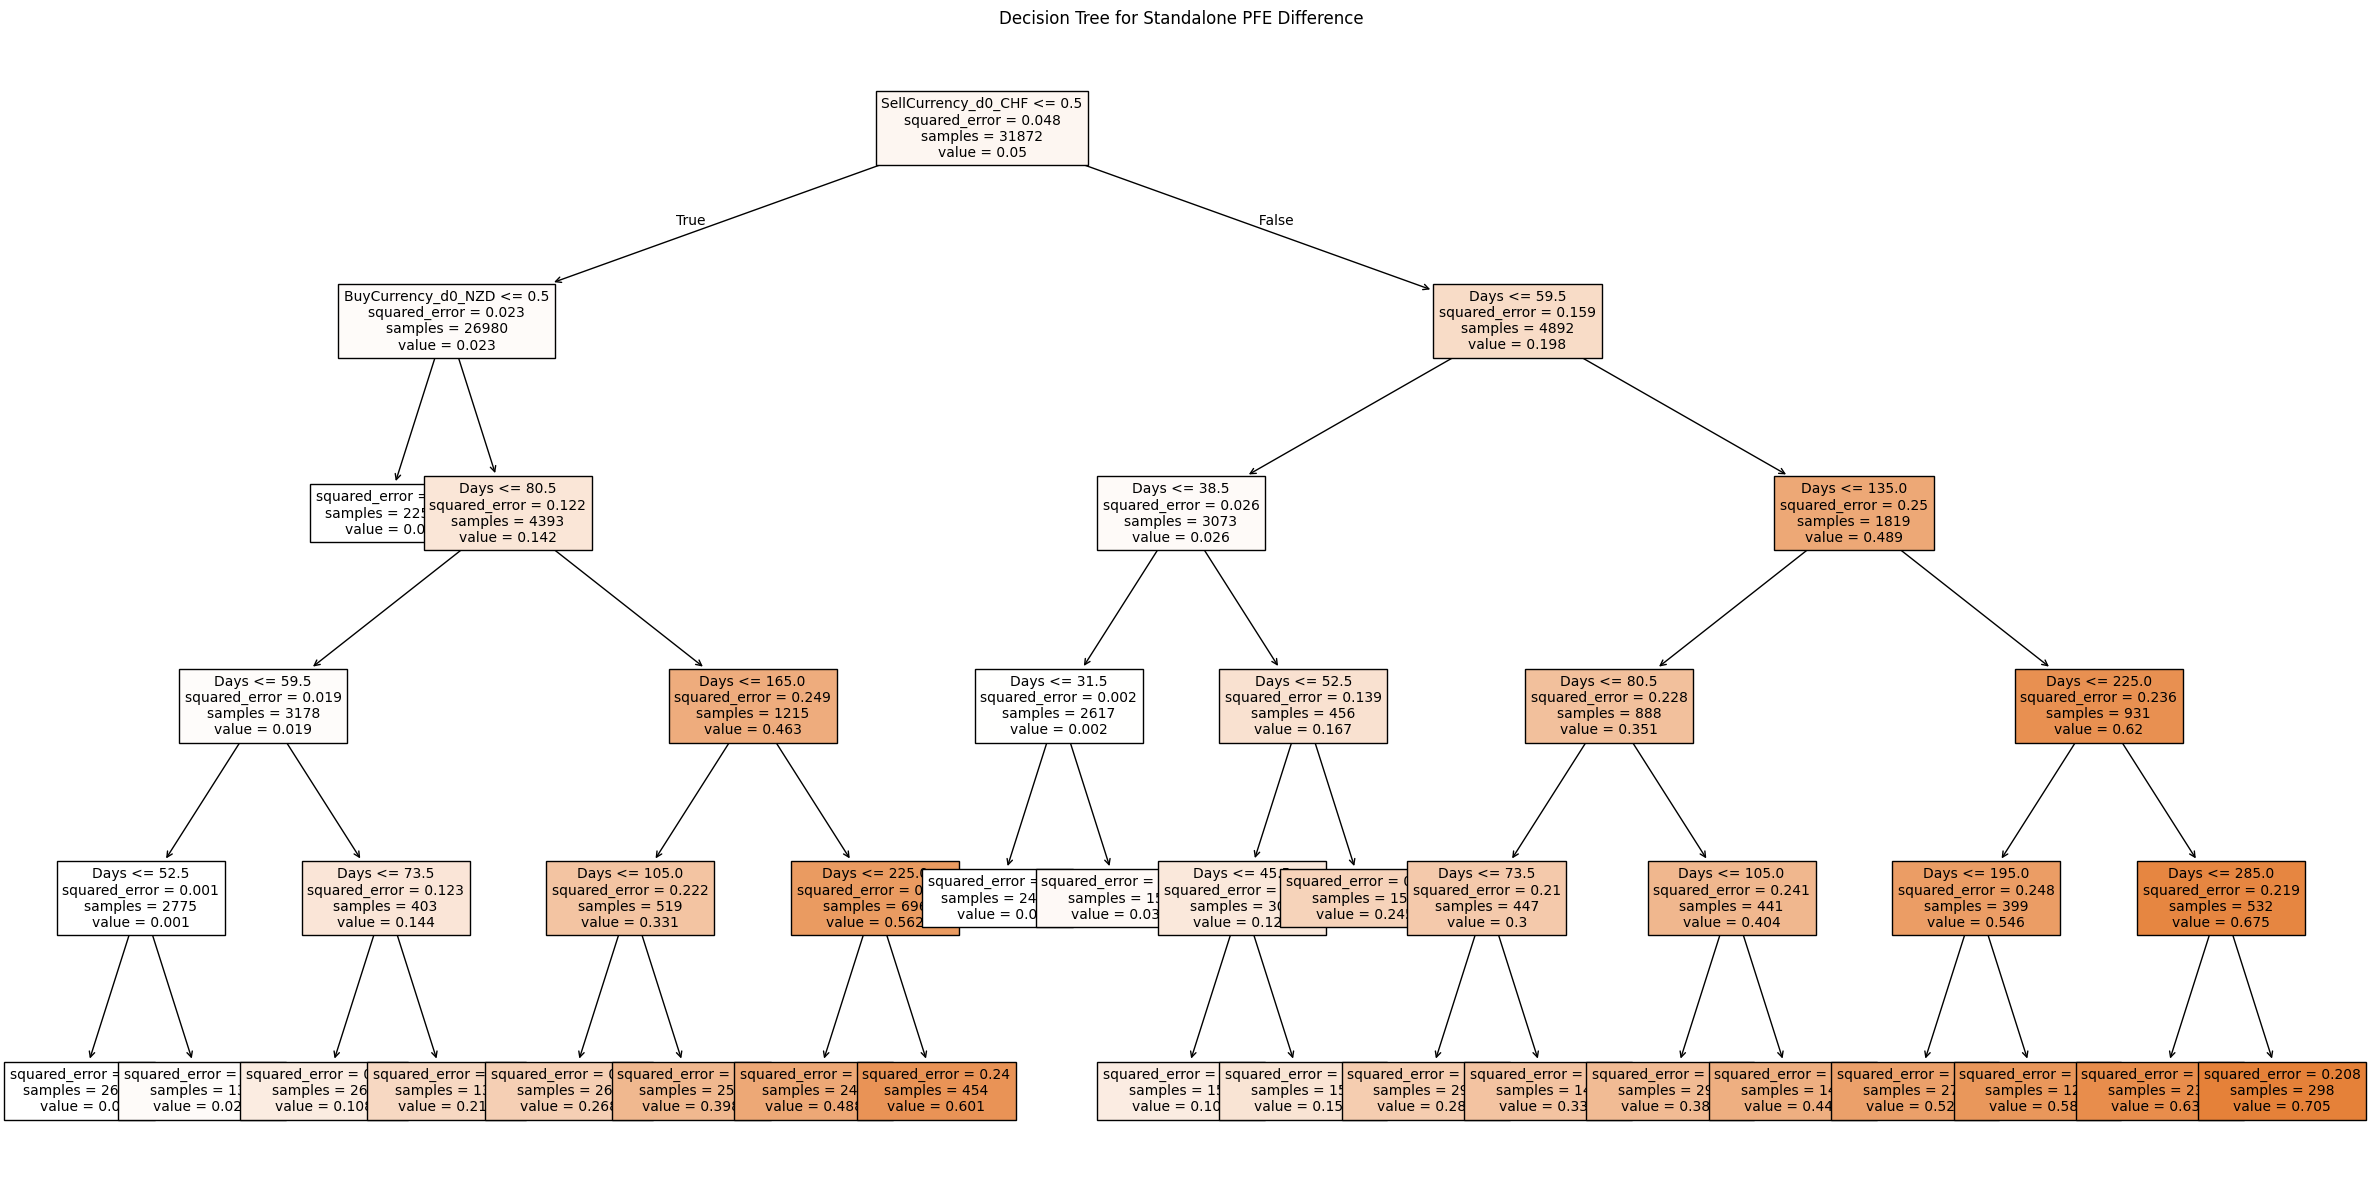

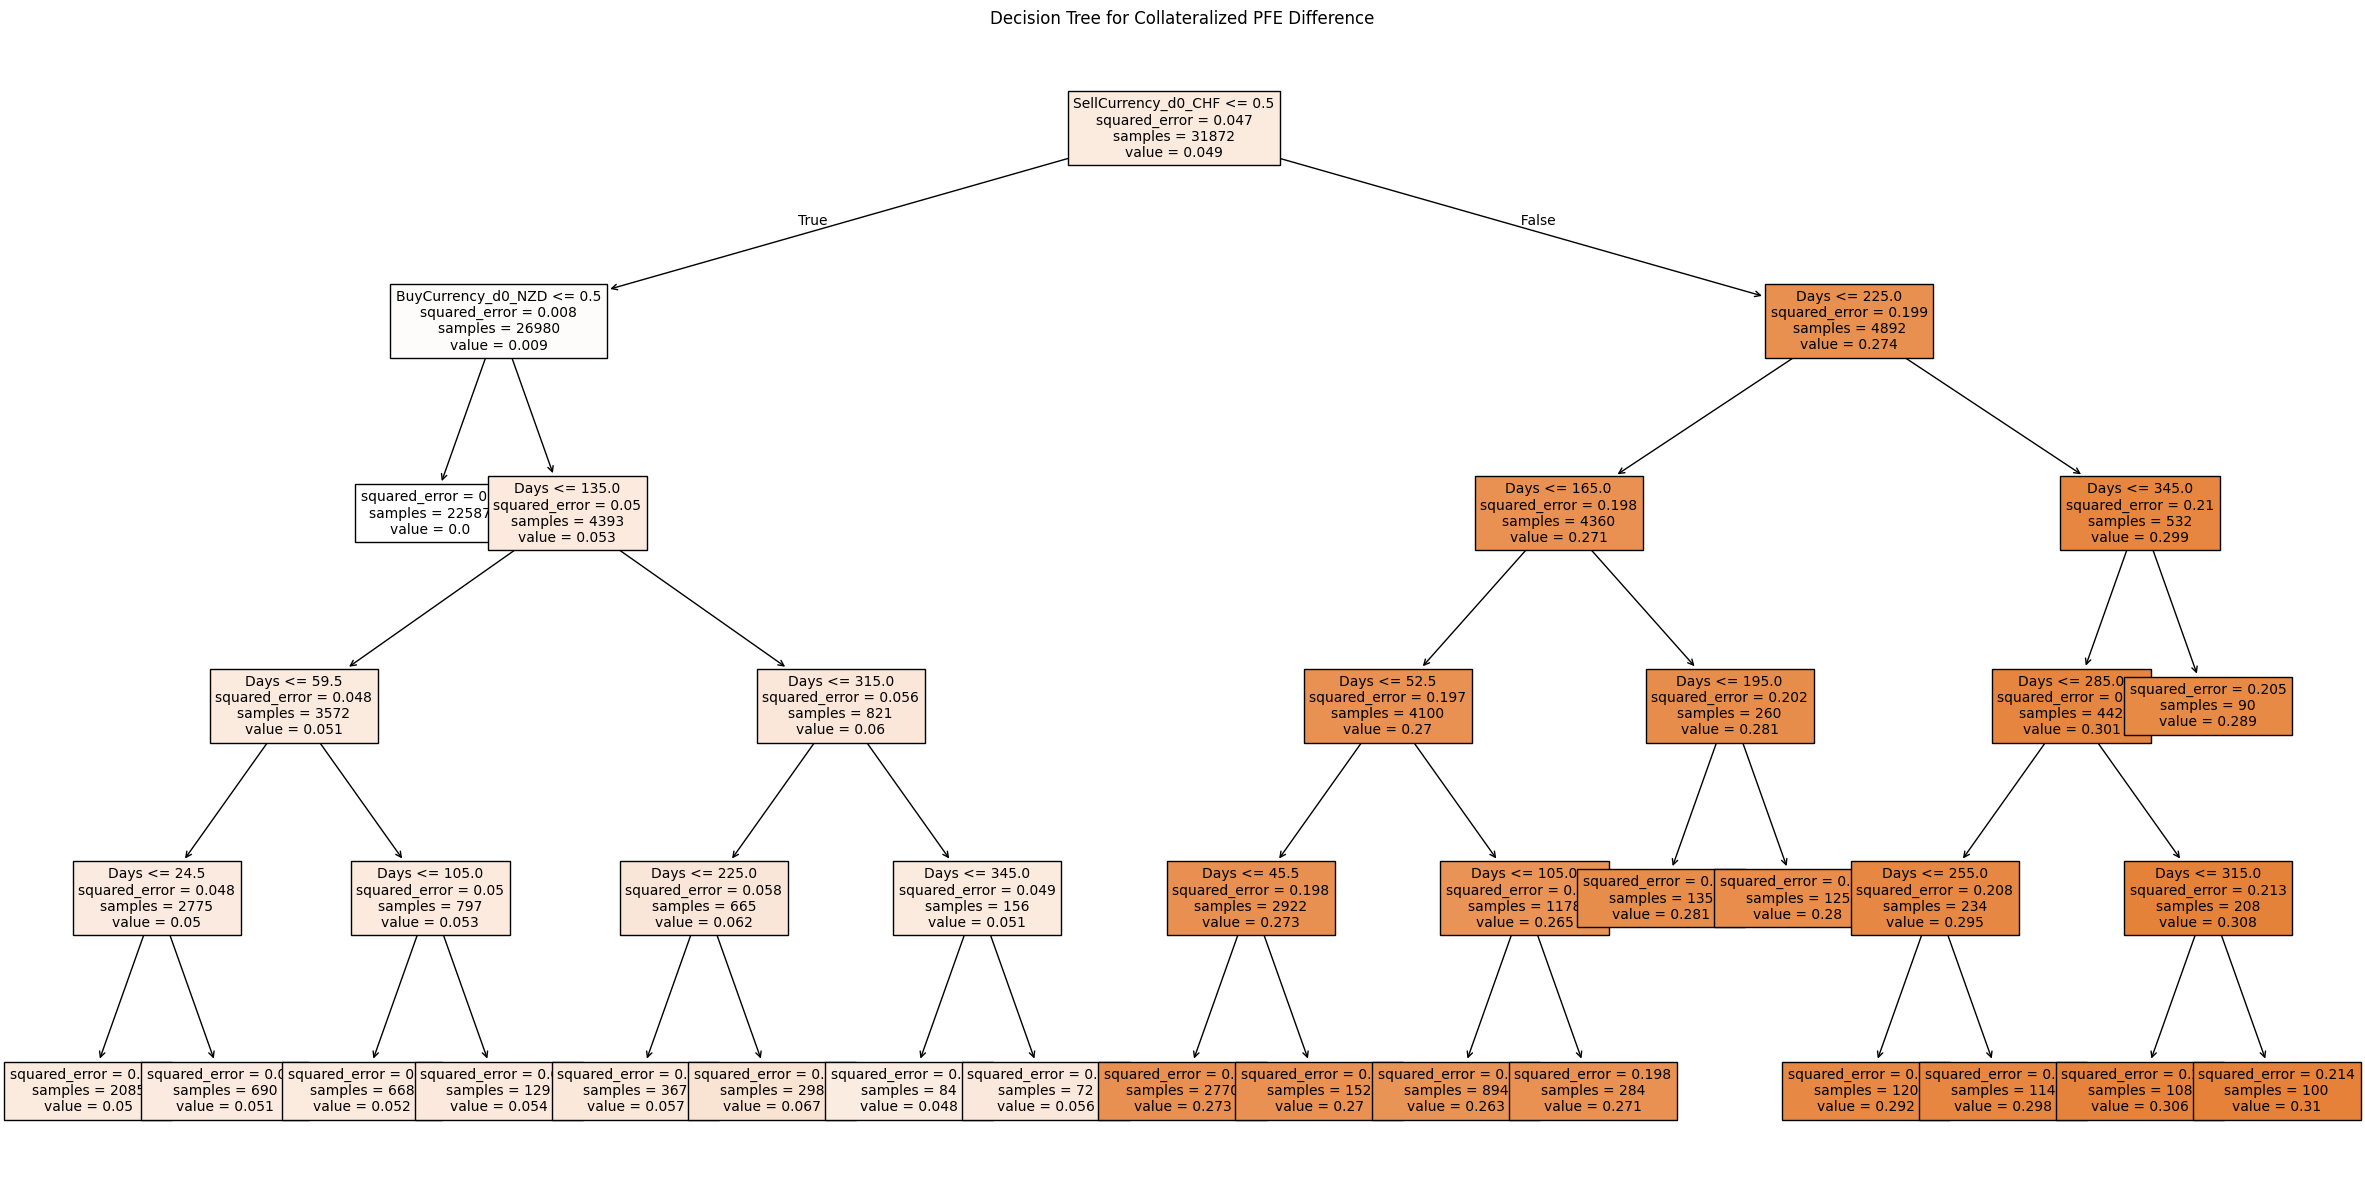

In [36]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Assume pfe_results_df and pfe_results_d1_df are already provided

# Perform an inner join on TransactionID and Days
merged_df = pd.merge(pfe_results_df, pfe_results_d1_df, on=['TransactionID', 'Days'], suffixes=('_d0', '_d1'))

# Calculate the differences
merged_df['Standalone_PFE_Diff'] = merged_df['Standalone_PFE_d1'] - merged_df['Standalone_PFE_d0']
merged_df['Collateralized_PFE_Diff'] = merged_df['Collateralized_PFE_d1'] - merged_df['Collateralized_PFE_d0']

# Set a significant threshold based on 95th percentile of the differences

# Standalone PFE Difference
standalone_threshold = np.percentile(abs(merged_df['Standalone_PFE_Diff']), 95)

# Collateralized PFE Difference
collateralized_threshold = np.percentile(abs(merged_df['Collateralized_PFE_Diff']), 95)

# Create binary labels
merged_df['Standalone_Significant'] = (abs(merged_df['Standalone_PFE_Diff']) > standalone_threshold).astype(int)
merged_df['Collateralized_Significant'] = (abs(merged_df['Collateralized_PFE_Diff']) > collateralized_threshold).astype(int)

# One-hot encode categorical features
categorical_features = ['BuyCurrency_d0', 'SellCurrency_d0']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = onehot_encoder.fit_transform(merged_df[categorical_features])
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine all features
final_features_df = pd.concat([merged_df[['Days']], encoded_df], axis=1)
# Define features and target for standalone PFE difference
X = final_features_df
y_standalone = merged_df['Standalone_Significant']
y_collateralized = merged_df['Collateralized_Significant']

# Train a Decision Tree for Standalone PFE Difference
tree_model_standalone = DecisionTreeRegressor(random_state=0, max_depth=5)
param_grid = {'random_state': np.arange(10)}
grid_search_standalone = GridSearchCV(tree_model_standalone, param_grid, cv=10, scoring='accuracy')
grid_search_standalone.fit(X, y_standalone)

# Get the best model
best_tree_model_standalone = grid_search_standalone.best_estimator_
best_tree_model_standalone.fit(X, y_standalone)

# Export the tree as text for Standalone PFE Difference
tree_rules_standalone = export_text(best_tree_model_standalone, feature_names=final_features_df.columns.to_list())

text = ''
text += 'Decision Tree Rules for Standalone PFE Difference:\n'
text += tree_rules_standalone

# Train a Decision Tree for Collateralized PFE Difference
tree_model_collateralized = DecisionTreeRegressor(random_state=0, max_depth=5)
param_grid = {'random_state': np.arange(10)}
grid_search_collateralized = GridSearchCV(tree_model_collateralized, param_grid, cv=10, scoring='accuracy')
grid_search_collateralized.fit(X, y_collateralized)

# Get the best model
best_tree_model_collateralized = grid_search_collateralized.best_estimator_
best_tree_model_collateralized.fit(X, y_collateralized)

# Export the tree as text for Collateralized PFE Difference
tree_rules_collateralized = export_text(best_tree_model_collateralized, feature_names=final_features_df.columns.to_list())

text += '\nDecision Tree Rules for Collateralized PFE Difference:\n'
text += tree_rules_collateralized

# print volatility and correlation matrix to string, concatenate and with headlines explaining them
volatilities_usd_text = 'Volatilities for USD pairs:\n'
volatilities_usd_text += str(volatilities_usd)
volatilities_usd_text += '\n\n'

correlation_matrix_usd_text = 'Correlation Matrix for USD pairs:\n'
correlation_matrix_usd_text += str(correlation_matrix_usd)
correlation_matrix_usd_text += '\n\n'

volatilities_usd_d1_text = 'Volatilities for USD pairs in d1:\n'
volatilities_usd_d1_text += str(volatilities_usd_d1)
volatilities_usd_d1_text += '\n\n'

correlation_matrix_usd_d1_text = 'Correlation Matrix for USD pairs in d1:\n'
correlation_matrix_usd_d1_text += str(correlation_matrix_usd_d1)
correlation_matrix_usd_d1_text += '\n\n'

# Combine all text
market_data_text = volatilities_usd_text + correlation_matrix_usd_text + volatilities_usd_d1_text + correlation_matrix_usd_d1_text

# Function to visualize a decision tree with improved readability
def visualize_tree(model, feature_names, title):
    plt.figure(figsize=(30, 15))  # Increase figure size for better readability
    tree.plot_tree(model, feature_names=feature_names, filled=True, fontsize=10)  # Adjust font size
    plt.title(title)
    plt.show()

# Visualize the Standalone PFE Difference Decision Tree
visualize_tree(best_tree_model_standalone, final_features_df.columns, "Decision Tree for Standalone PFE Difference")

# Visualize the Collateralized PFE Difference Decision Tree
visualize_tree(best_tree_model_collateralized, final_features_df.columns, "Decision Tree for Collateralized PFE Difference")


In [37]:
merged_df

,TransactionID,Counterparty_d0,BuyCurrency_d0,SellCurrency_d0,MaturityDate_d0,Days,Standalone_PFE_d0,Collateralized_PFE_d0,Counterparty_d1,BuyCurrency_d1,SellCurrency_d1,MaturityDate_d1,Standalone_PFE_d1,Collateralized_PFE_d1,Standalone_PFE_Diff,Collateralized_PFE_Diff,Standalone_Significant,Collateralized_Significant
0,27235278,Smith-Alexander,USD,CAD,2024-07-09,1,7.690049e+05,2.431807e+06,Smith-Alexander,USD,CAD,2024-07-09,9.464675e+05,2.992993e+06,1.774627e+05,5.611862e+05,0,0
1,27235278,Smith-Alexander,USD,CAD,2024-07-09,2,1.087537e+06,2.431807e+06,Smith-Alexander,USD,CAD,2024-07-09,1.338507e+06,2.992993e+06,2.509701e+05,5.611862e+05,0,0
2,27235278,Smith-Alexander,USD,CAD,2024-07-09,3,1.331956e+06,2.431807e+06,Smith-Alexander,USD,CAD,2024-07-09,1.639330e+06,2.992993e+06,3.073743e+05,5.611862e+05,0,0
3,27235278,Smith-Alexander,USD,CAD,2024-07-09,4,1.538010e+06,2.431807e+06,Smith-Alexander,USD,CAD,2024-07-09,1.892935e+06,2.992993e+06,3.549253e+05,5.611862e+05,0,0
4,27235278,Smith-Alexander,USD,CAD,2024-07-09,5,1.719547e+06,2.431807e+06,Smith-Alexander,USD,CAD,2024-07-09,2.116366e+06,2.992993e+06,3.968186e+05,5.611862e+05,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31867,86877860,Odom-Montgomery,USD,CAD,2025-01-13,240,2.422647e+07,4.945208e+06,Odom-Montgomery,USD,CAD,2025-01-13,2.981720e+07,6.086410e+06,5.590724e+06,1.141202e+06,0,0
31868,86877860,Odom-Montgomery,USD,CAD,2025-01-13,270,2.569605e+07,4.945208e+06,Odom-Montgomery,USD,CAD,2025-01-13,3.162591e+07,6.086410e+06,5.929859e+06,1.141202e+06,0,0
31869,86877860,Odom-Montgomery,USD,CAD,2025-01-13,300,2.708602e+07,4.945208e+06,Odom-Montgomery,USD,CAD,2025-01-13,3.333664e+07,6.086410e+06,6.250620e+06,1.141202e+06,0,0
31870,86877860,Odom-Montgomery,USD,CAD,2025-01-13,330,2.840806e+07,4.945208e+06,Odom-Montgomery,USD,CAD,2025-01-13,3.496376e+07,6.086410e+06,6.555706e+06,1.141202e+06,0,0


In [38]:
final_features_df

,Days,BuyCurrency_d0_EUR,BuyCurrency_d0_GBP,BuyCurrency_d0_NZD,BuyCurrency_d0_USD,SellCurrency_d0_CHF,SellCurrency_d0_JPY,SellCurrency_d0_USD
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
31867,240,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31868,270,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31869,300,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31870,330,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [39]:
print(text)

Decision Tree Rules for Standalone PFE Difference:
|--- SellCurrency_d0_CHF <= 0.50
|   |--- BuyCurrency_d0_NZD <= 0.50
|   |   |--- value: [0.00]
|   |--- BuyCurrency_d0_NZD >  0.50
|   |   |--- Days <= 80.50
|   |   |   |--- Days <= 59.50
|   |   |   |   |--- Days <= 52.50
|   |   |   |   |   |--- value: [0.00]
|   |   |   |   |--- Days >  52.50
|   |   |   |   |   |--- value: [0.02]
|   |   |   |--- Days >  59.50
|   |   |   |   |--- Days <= 73.50
|   |   |   |   |   |--- value: [0.11]
|   |   |   |   |--- Days >  73.50
|   |   |   |   |   |--- value: [0.22]
|   |   |--- Days >  80.50
|   |   |   |--- Days <= 165.00
|   |   |   |   |--- Days <= 105.00
|   |   |   |   |   |--- value: [0.27]
|   |   |   |   |--- Days >  105.00
|   |   |   |   |   |--- value: [0.40]
|   |   |   |--- Days >  165.00
|   |   |   |   |--- Days <= 225.00
|   |   |   |   |   |--- value: [0.49]
|   |   |   |   |--- Days >  225.00
|   |   |   |   |   |--- value: [0.60]
|--- SellCurrency_d0_CHF >  0.50
|   |---

In [40]:
print(market_data_text)

Volatilities for USD pairs:
{'EUR': 0.1, 'JPY': 0.15, 'GBP': 0.12, 'CHF': 0.1, 'CAD': 0.13, 'AUD': 0.14, 'NZD': 0.15}

Correlation Matrix for USD pairs:
[[1.  0.3 0.2 0.1 0.1 0.2 0.1]
 [0.3 1.  0.4 0.2 0.2 0.1 0.2]
 [0.2 0.4 1.  0.3 0.3 0.2 0.3]
 [0.1 0.2 0.3 1.  0.4 0.3 0.2]
 [0.1 0.2 0.3 0.4 1.  0.2 0.1]
 [0.2 0.1 0.2 0.3 0.2 1.  0.4]
 [0.1 0.2 0.3 0.2 0.1 0.4 1. ]]

Volatilities for USD pairs in d1:
{'EUR': 0.12, 'JPY': 0.15, 'GBP': 0.12, 'CHF': 0.2, 'CAD': 0.16, 'AUD': 0.14, 'NZD': 0.2}

Correlation Matrix for USD pairs in d1:
[[1.  0.3 0.2 0.1 0.1 0.2 0.1]
 [0.3 1.  0.4 0.2 0.2 0.1 0.2]
 [0.2 0.4 1.  0.3 0.3 0.2 0.3]
 [0.1 0.2 0.3 1.  0.4 0.3 0.2]
 [0.1 0.2 0.3 0.4 1.  0.2 0.1]
 [0.2 0.1 0.2 0.3 0.2 1.  0.4]
 [0.1 0.2 0.3 0.2 0.1 0.4 1. ]]




In [41]:
system_prompt = """You will be given a PFE difference tree for both collateralized and uncollateralized standalone trades between two days. 
Additionally, market data inputs such as volatility and spot rates for both days will be provided.
Note that the columns with categorical features are one-hot encoded.
Also the differences in PFE are calculated for each trade and the significant differences are identified based on a threshold, which is what the decision tree is trained on.
When you see that the number of days are affecting the PFE, it is likely to be due to volatility and correlation changes.
For FX trades that are uncollateralized, it is expected that the PFE will increase with number of days in the future, but that's not as expected for collateralized trades.

Your task is to compare the differences between the two days, analyze the key factors driving the changes, and summarize your findings. Specifically, please:

1. Identify the primary drivers for the differences in PFE. Note that many features are one-hot encoded, so you may need to interpret the rules accordingly.
2. Explain how changes in market data (e.g., volatility, spot rates) are impacting the PFE calculations.
3. Highlight any significant patterns or anomalies in the decision tree.
4. Provide recommendations on what we should examine further based on your analysis. Note that we are only interested in the computational aspects of the analysis, not the business implications.

Finally please provide an executive summary on the next steps and investigations that should be conducted based on your analysis.
"""

In [42]:
#Parse out the response
print(response.choices[0].message.content)

NameError: name 'response' is not defined